# NOTE: THE MODEL IN THIS NOTEBOOK SHOULD NOT BE USED FOR REPORTING PURPOSES. IT IS ONLY PRESERVED FOR PERSONAL REFERENCE.

## THIS NOTEBOOK'S ERROR CONSISTS IN USING THE ROLLING JOBS ENDED PER HOUR COLUMN ON THE SLURM_JOBS DF TOGETHER WITH CHECKING FOR ANY PREVIOUS UNRESPONSIVENESS FROM LOG COMMANDS WITHIN THAT SAME HOUR. THIS IS A PROBLEM FOR TWO REASONS:

1. Constructing the rolling jobs ended per hour is fine for investigating the general trend of jobs ended per hour throughout the year, as in notebook 1. However, when constructing a model that compares jobs completed per hour to unresponsive commands within the hour, a rolling window over the jobs will put too much weight on high-volume periods. Specifically, each event in the high-colume period gets a data point, which also allows for more checks of unresponsiveness. This leads to the second issue with this model.
2. Checks for unresponsiveness looked for *any* event of unresponsiveness within the window, which might be too sensitive, especially since high-volume times will count the same events of unresponsiveness many times due to all the ending jobs serving as data points.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import seaborn as sns
import re
from jupyterthemes import jtplot
from datetime import timedelta, datetime
import calendar
import plotly.express as px
#jtplot.style()

In [2]:
def getlogs(server):
    """Get server logs and format for analysis"""
    x = pd.read_csv(f'../data/slurm_wrapper_{server}.log', 
                      sep = ' - ', 
                      engine = 'python', 
                      names = ['DATETIME', 'USER', 'RETRY', 'TIMELAPSE', 'RETURNCODE', 'COMMAND'])
    x['DATETIME'] = pd.to_datetime(x['DATETIME'])
    x['USER'] = x['USER'].str.extract(r'(\d+)')
    x['RETRY'] = x['RETRY'].str.extract('(\d+)').astype('int')
    x['TIMELAPSE'] = x['TIMELAPSE'].str.replace('time ', '').astype('float')
    x['RETURNCODE'] = x['RETURNCODE'].str.extract('(\d+)')
    x['JOBID'] = x['COMMAND'].str.extract(r"'(\d{8})'")
    x['COMMANDTYPE'] = x['COMMAND'].str.extract(r"bin/(s\w+)'")
    x['TESTING'] = (x['COMMANDTYPE'] == 'sbatch') & (x['USER'] == '9204')
    x['UNRESPONSIVE'] = (x['TIMELAPSE'] >= 15) & (x['RETURNCODE'] == '1')
    x['SERVER'] = f'{server}'
    return x

In [3]:
ce5 = getlogs('ce5')
ce6 = getlogs('ce6')

In [4]:
ce = pd.concat([ce5, ce6]).sort_values('DATETIME').reset_index(drop = True)

## Problem 4

Finally, combine the time series information from the two datasets together to see 

(4A) how well correlated heavy job-completion load is with the unresponsiveness, and 

(4B) to see if there is some threshold of job completions per hour that generally results in unresponsiveness.

In [5]:
slurm_jobs = pd.read_csv('../data/slurm_jobs.csv')

In [6]:
datetime_cols = ['BEGIN', 'END']
for col in datetime_cols:
    slurm_jobs[col] = pd.to_datetime(slurm_jobs[col])

timedelta_cols = ['REQTIME', 'USEDTIME']
for col in timedelta_cols:
    slurm_jobs[col] = pd.to_timedelta(slurm_jobs[col])

In [7]:
# regex = re.compile(r'((?P<hours>\d+?)h)?((?P<minutes>\d+?)m)?((?P<seconds>\d+?)s)?')

# def parse_time(time_str):
#     parts = regex.match(time_str)
#     if not parts:
#         return
#     parts = parts.groupdict()
#     time_params = {}
#     for name, param in parts.items():
#         if param:
#             time_params[name] = int(param)
#     return timedelta(**time_params)

In [8]:
# def check_unresponsive(x, window = '1h'):
#     cef = ce.loc[(ce['DATETIME'] >= x - parse_time(window))
#                  &
#                  (ce['DATETIME'] <= x)]
#     unresp = cef['UNRESPONSIVE'].any()
#     return unresp

In [9]:
#slurm_jobs['END'].apply(check_unresponsive)

In [10]:
slurm_jobs.head()

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,TIMEOUT,SIGNAL,IN_ARRAY,ARRAYID,ROLL1HR
0,24460577,COMPLETED,2020-10-01 00:05:55,2020-10-01 00:10:15,4096Mc,868.77M,0 days 12:00:00,0 days 00:04:20,1,1,production,0,False,0,False,NaN,1.0
1,24460647,COMPLETED,2020-10-01 00:10:38,2020-10-01 00:12:58,2000Mn,0.09M,2 days 00:00:00,0 days 00:02:20,1,1,sam,0,False,0,False,NaN,2.0
2,24460639,COMPLETED,2020-10-01 00:11:22,2020-10-01 00:13:31,1024Mc,221.10M,0 days 00:30:00,0 days 00:02:09,1,1,production,0,False,0,False,NaN,3.0
3,24460668,COMPLETED,2020-10-01 00:15:16,2020-10-01 00:17:23,2000Mn,0.09M,2 days 00:00:00,0 days 00:02:07,1,1,sam,0,False,0,False,NaN,4.0
4,24460671,FAILED,2020-10-01 00:17:08,2020-10-01 00:17:53,1024Mc,636.96M,0 days 00:30:00,0 days 00:00:45,1,1,production,0,False,9,False,NaN,5.0


## (4A) How well correlated is heavy job-completion load with unresponsiveness?

-- Mix in logs (ce) with jobs (slurm_jobs)

    * subset ce into relevant columns; call it c
    * concatenate slurm_jobs and c; call it slurm_c
    
-- Create rolling window to check for unresponsivenss

    * sort and reset index of slurm_c
    * create rolling window to determine whether the scheduler was unresponsive within the hour prior to each job (returning True/False or 1/0). This will allow us to correlate ROLL1HR with unresponsivenss ('ROLL1HRUR')
    * filter out null columns to make slurm_cf
    
-- Make logistic regression model

    * Make the base model with sm.GLM
    * Make the model with ROLL1HR as exog
    * Plot the model
    * Make model with Logit to confirm results and to construct confusion matrix

### Mix in logs (ce) with jobs (slurm_jobs)

In [11]:
c = ce[['DATETIME', 'TESTING', 'UNRESPONSIVE']]
c = c.rename(columns = {'DATETIME' : 'END'})

In [12]:
slurm_c = pd.concat([slurm_jobs, c])

### Create rolling window to check for unresponsivenss

In [13]:
slurm_c = slurm_c.sort_values('END').reset_index(drop = True)

In [14]:
slurm_c['ROLL1HRUR'] = (slurm_c
        .rolling('1h', on = 'END')
        ['UNRESPONSIVE']
        .max()
)

In [15]:
slurm_cf = slurm_c[~slurm_c['JOBID'].isnull()].dropna(subset = ['ROLL1HR', 'ROLL1HRUR'])

### Make logistic regression model: ROLL1HR model shows AIC improvement over base model. Significant result: With each increase of 100 jobs per hour, the odds of unresponsiveness increases by 1.0144 times. e.g. The model predicts that the odds of unresponsiveness are 1.0144 times higher at 800 jobs per hour than they are at 700 jobs per hour.

In [16]:
logreg_unresponsive_base = (sm.GLM(endog = slurm_cf['ROLL1HRUR'],
                       exog = sm.add_constant(slurm_cf[[]]),
                       family = sm.families.Binomial(),
                      )
                  .fit()
               )
print(logreg_unresponsive_base.summary(), '\n\n')
print('Base AIC: '+str(logreg_unresponsive_base.aic))

                 Generalized Linear Model Regression Results                  
Dep. Variable:              ROLL1HRUR   No. Observations:              7012655
Model:                            GLM   Df Residuals:                  7012654
Model Family:                Binomial   Df Model:                            0
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.8582e+06
Date:                Mon, 08 Nov 2021   Deviance:                   9.7164e+06
Time:                        20:44:35   Pearson chi2:                 7.01e+06
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0547      0.001     72.428      0.0

In [17]:
logreg_unresponsive_roll = (sm.GLM(endog = slurm_cf['ROLL1HRUR'],
                       exog = sm.add_constant(slurm_cf['ROLL1HR']),
                       family = sm.families.Binomial(),
                      )
                  .fit()
               )
print(logreg_unresponsive_roll.summary(), '\n\n')
print('Base AIC: '+str(logreg_unresponsive_base.aic))
print('Logistic AIC: '+str(logreg_unresponsive_roll.aic))

                 Generalized Linear Model Regression Results                  
Dep. Variable:              ROLL1HRUR   No. Observations:              7012655
Model:                            GLM   Df Residuals:                  7012653
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.7367e+06
Date:                Mon, 08 Nov 2021   Deviance:                   9.4734e+06
Time:                        20:44:53   Pearson chi2:                 7.02e+06
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2717      0.001   -267.214      0.0

### Plot the model: No responsive hours with jobs per hour over 12,934

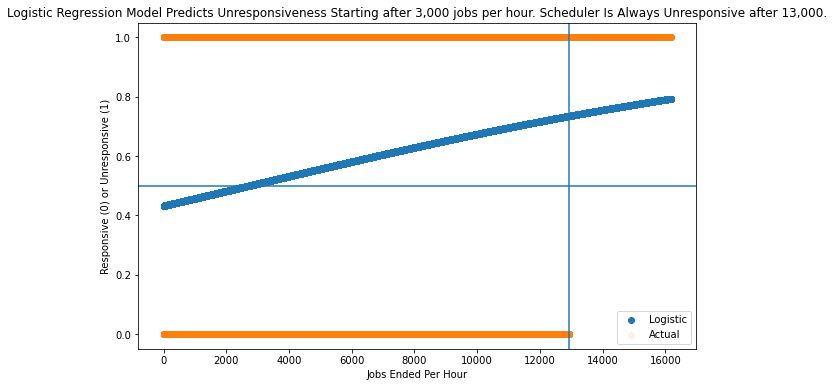

In [18]:
fig, ax = plt.subplots(figsize = (10,6))

x = slurm_cf['ROLL1HR']
y_logistic = 1/(1+np.exp(-(-0.2717 + (0.0001*x))))
plt.scatter(x, y_logistic, label = 'Logistic')

x = slurm_cf['ROLL1HR']
y = slurm_cf['ROLL1HRUR']
plt.scatter(x, y, label = 'Actual', alpha = 0.1)
ax.axhline(0.5)
ax.axvline(slurm_cf.loc[slurm_cf['ROLL1HRUR'] == False, 'ROLL1HR'].max())
plt.legend()
plt.title("Logistic Regression Model Predicts Unresponsiveness Starting after 3,000 jobs per hour. Scheduler Is Always Unresponsive after 13,000.")
plt.ylabel("Responsive (0) or Unresponsive (1)")
plt.xlabel("Jobs Ended Per Hour");

C:\Users\jrior\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


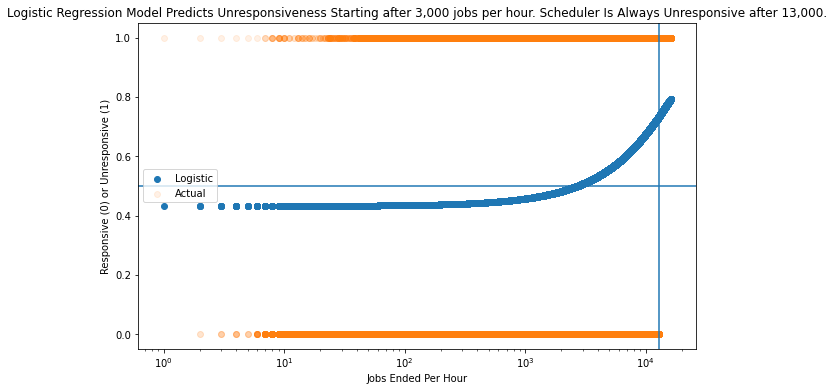

In [19]:
fig, ax = plt.subplots(figsize = (10,6))

x = slurm_cf['ROLL1HR']
y_logistic = 1/(1+np.exp(-(-0.2717 + (0.0001*x))))
plt.scatter(x, y_logistic, label = 'Logistic')

x = slurm_cf['ROLL1HR']
y = slurm_cf['ROLL1HRUR']
plt.scatter(x, y, label = 'Actual', alpha = 0.1)
ax.set(xscale = 'log')
ax.axhline(0.5)
ax.axvline(slurm_cf.loc[slurm_cf['ROLL1HRUR'] == False, 'ROLL1HR'].max())
plt.legend()
plt.title("Logistic Regression Model Predicts Unresponsiveness Starting after 3,000 jobs per hour. Scheduler Is Always Unresponsive after 13,000.")
plt.ylabel("Responsive (0) or Unresponsive (1)")
plt.xlabel("Jobs Ended Per Hour");

### Confirm the model

In [20]:
model = sm.Logit(slurm_cf['ROLL1HRUR'], sm.add_constant(slurm_cf['ROLL1HR']))
result = model.fit(method = 'newton')
result.params

Optimization terminated successfully.
         Current function value: 0.675453
         Iterations 5


const     -0.271701
ROLL1HR    0.000143
dtype: float64

### Check the model using the confusion matrix. We're better at predicting unresponsiveness than responsiveness, but still not great overall. But, importantly, we get better at predicting unresponsiveness as ROLL1HR increases.

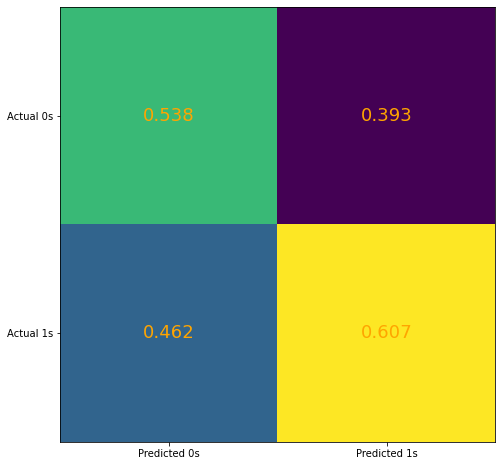

In [21]:
cm = np.round(result.pred_table()/sum(result.pred_table()),3)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='orange', size = 18)
plt.show()

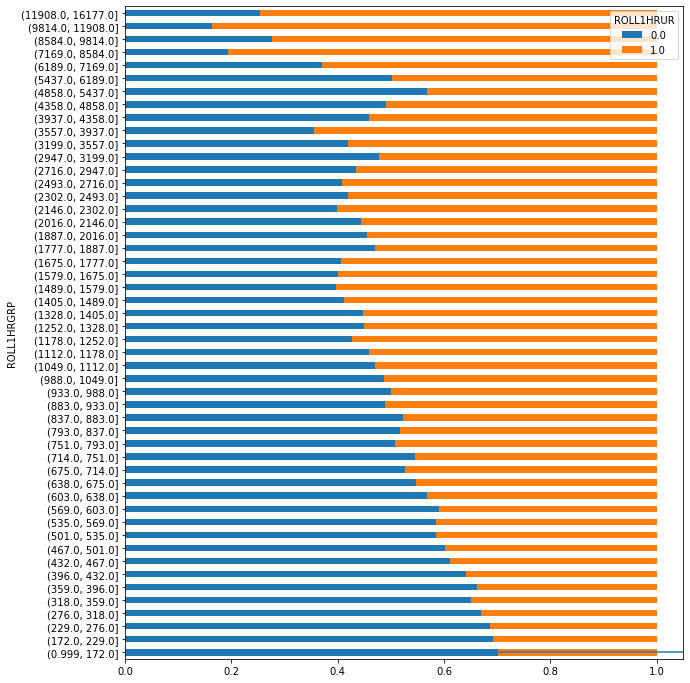

In [22]:
slurm_cf['ROLL1HRGRP'] = pd.qcut(slurm_cf['ROLL1HR'], q = 50)

fig, ax = plt.subplots(figsize = (10,12))

(slurm_cf.groupby(['ROLL1HRGRP', 'ROLL1HRUR'])
         ['JOBID']
         .count()/slurm_cf.groupby('ROLL1HRGRP')['JOBID'].count()
).unstack().plot(kind = 'barh', stacked = True, ax = ax)
ax.axhline()

In [23]:
slurm_cf.loc[slurm_cf['ROLL1HR'] >= 12856.0, 'ROLL1HRUR'].mean()

0.9494097305032196

In [24]:
slurm_cf.loc[slurm_cf['ROLL1HR'] >= 12856.0, 'END'].apply(lambda x: x.date()).unique()

array([datetime.date(2020, 12, 11), datetime.date(2021, 8, 11),
       datetime.date(2021, 8, 12), datetime.date(2021, 8, 31),
       datetime.date(2021, 9, 1), datetime.date(2021, 9, 13)],
      dtype=object)